<a href="https://colab.research.google.com/github/niltontac/EspAnalise-EngDados/blob/master/Website_Phishing_AplicandoModelosDeClassificacao_KNN_RF_TREE_PCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Website Phishing Data
#Aplicando modelos de classificação.

###Importando Bibliotecas

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


###Carregando dataset

In [2]:
data = pd.read_csv('https://raw.githubusercontent.com/niltontac/EspAnalise-EngDados/master/data/PhishingData.csv')
data

,SFH,popUpWidnow,SSLfinal_State,Request_URL,URL_of_Anchor,web_traffic,URL_Length,age_of_domain,having_IP_Address,Result
0,1,-1,1,-1,-1,1,1,1,0,0
1,-1,-1,-1,-1,-1,0,1,1,1,1
2,1,-1,0,0,-1,0,-1,1,0,1
3,1,0,1,-1,-1,0,1,1,0,0
4,-1,-1,1,-1,0,0,-1,1,0,1
...,...,...,...,...,...,...,...,...,...,...
1348,-1,-1,-1,-1,-1,-1,0,1,0,1
1349,-1,0,1,0,-1,0,0,1,0,-1
1350,-1,0,-1,-1,-1,0,-1,-1,0,1
1351,0,0,1,0,0,0,-1,1,0,1


###Análise exploratória dos dados

In [3]:
# Dimensões do dataset (linhas x colunas)
data.shape

(1353, 10)

In [4]:
# Informações do dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1353 entries, 0 to 1352
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   SFH                1353 non-null   int64
 1   popUpWidnow        1353 non-null   int64
 2   SSLfinal_State     1353 non-null   int64
 3   Request_URL        1353 non-null   int64
 4   URL_of_Anchor      1353 non-null   int64
 5   web_traffic        1353 non-null   int64
 6   URL_Length         1353 non-null   int64
 7   age_of_domain      1353 non-null   int64
 8   having_IP_Address  1353 non-null   int64
 9   Result             1353 non-null   int64
dtypes: int64(10)
memory usage: 105.8 KB


In [5]:
# Descrição resumida do dataset incluíndo tendência central, dispersão e distribuição
data.describe()

,SFH,popUpWidnow,SSLfinal_State,Request_URL,URL_of_Anchor,web_traffic,URL_Length,age_of_domain,having_IP_Address,Result
count,1353.000000,1353.000000,1353.000000,1353.000000,1353.000000,1353.000000,1353.000000,1353.000000,1353.000000,1353.000000
mean,0.237990,-0.258684,0.327421,-0.223208,-0.025129,0.000000,-0.053215,0.219512,0.114560,-0.113821
std,0.916389,0.679072,0.822193,0.799682,0.936262,0.806776,0.762552,0.975970,0.318608,0.954773
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000,-1.000000
25%,-1.000000,-1.000000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000,-1.000000
50%,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,-1.000000
75%,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [6]:
# Consultando se há dados ausentes ou nulos
print(data.isnull().sum())
print(data.isna().sum())

SFH                  0
popUpWidnow          0
SSLfinal_State       0
Request_URL          0
URL_of_Anchor        0
web_traffic          0
URL_Length           0
age_of_domain        0
having_IP_Address    0
Result               0
dtype: int64
SFH                  0
popUpWidnow          0
SSLfinal_State       0
Request_URL          0
URL_of_Anchor        0
web_traffic          0
URL_Length           0
age_of_domain        0
having_IP_Address    0
Result               0
dtype: int64


In [7]:
# Consultando a distribuição dos registros de classe do atributo alvo 'Result'

# Result  0  = suspicious
# Result  1  = legitimate
# Result -1  = phishing

suspicious = len(data[data.Result==0])
legitimate = len(data[data.Result==1])
phishing = len(data[data.Result==-1])

print(suspicious, 'registros de sites classificados como suspeitos (0)')
print(legitimate, 'registros de sites classificados como legítimos (1)')
print(phishing, 'registros de sites classificados como phishing (-1)')
print('array', data.Result.unique())


103 registros de sites classificados como suspeitos (0)
548 registros de sites classificados como legítimos (1)
702 registros de sites classificados como phishing (-1)
array [ 0  1 -1]


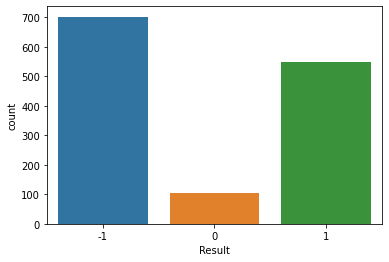

In [8]:
# Visualizando a distribuição dos registros de classe do atributo alvo
sns.countplot(data['Result'])

O gráfico acima nos mostra que há um desbalanceamento do atributo alvo (coluna 'Result'), onde há bem menos registros classificados como suspeitos.

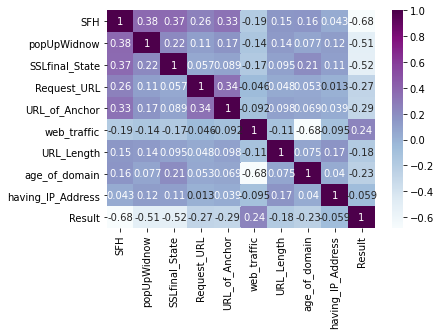

In [9]:
# Visualizando a correlação entre todos atributos e o atributo alvo('Result')
sns.heatmap(data.corr(), annot=True, cmap='BuPu')

A correlação ajuda a entender o grau de importância/influência entre o atributo alvo ('Result') com os demais atributos preditores, além da correlação entre os próprios atributos preditores. Por exemplo, existe uma forte correlação positiva entre os atributos 'SFH' e 'popUpWidnow'. Assim como existe uma forte correlação negativa entre os atributos 'age_of_domain' e 'web_traffic'.

### Selecionando 3 modelos de classificação para avaliação e comparação

In [10]:
# Modelos classificadores selecionados
clf_knn = KNeighborsClassifier(p=30) # KNN definido com profundidade de 30 vizinhos mais próximos
clf_rf = RandomForestClassifier(n_estimators=300) # RANDOM FOREST definido com estimativa de 300 amostras de treinamento
clf_tree = DecisionTreeClassifier(criterion='entropy') # DECISION TREE definido com função de entropy para medir qualidade da divisão da árvore 

print(clf_knn)
print(clf_rf)
print(clf_tree)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=30,
                     weights='uniform')
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_sample

###Dividindo o dataset em treino e teste

In [11]:
# Criando matriz de X e y
X = data.drop(['Result'], axis=1).values
y = data['Result'].values

print('--> Array de X:\n', X, '\n')

print('--> Array de y:\n', y)

--> Array de X:
 [[ 1 -1  1 ...  1  1  0]
 [-1 -1 -1 ...  1  1  1]
 [ 1 -1  0 ... -1  1  0]
 ...
 [-1  0 -1 ... -1 -1  0]
 [ 0  0  1 ... -1  1  0]
 [ 1  0  1 ... -1 -1  0]] 

--> Array de y:
 [ 0  1  1 ...  1  1 -1]


In [12]:
# Dados de X e y para treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

print('Conjunto de treino com {} elementos'.format(X_train.shape[0]))
print('Conjunto de teste com {} elementos'.format(X_test.shape[0]))

Conjunto de treino com 947 elementos
Conjunto de teste com 406 elementos


In [13]:
# Treinamento dos dados pelo modelos classificadores
clf_knn.fit(X_train, y_train)
clf_rf.fit(X_train, y_train)
clf_tree.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

###Treinando os modelos de classificação

In [14]:
# Criando uma lista para calcular as métricas de accuracy, precision, recall e f1_macro
scoring_list = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']

scores_knn = cross_validate(clf_knn, X, y, cv=5, scoring=scoring_list)
scores_rf = cross_validate(clf_rf, X, y, cv=5, scoring=scoring_list)
scores_tree = cross_validate(clf_tree, X, y, cv=5, scoring=scoring_list)

avg_scores_knn = []
avg_scores_rf = []
avg_scores_tree = []

for score in scoring_list:
  avg_scores_knn.append(scores_knn['test_'+score].mean())
  avg_scores_rf.append(scores_rf['test_'+score].mean())
  avg_scores_tree.append(scores_tree['test_'+score].mean())

print('KNN - ', avg_scores_knn)
print('RANDOM FOREST - ', avg_scores_rf)
print('TREE - ', avg_scores_tree)

KNN -  [0.8721525215252152, 0.8137432672983694, 0.7781972791127583, 0.7905473494431128]
RANDOM FOREST -  [0.8980183135164685, 0.881056545225442, 0.8550025477158018, 0.866106078976029]
TREE -  [0.8810222768894356, 0.8635094500404887, 0.8743710747360953, 0.8676691995166124]


###Comparando os modelos de classificação

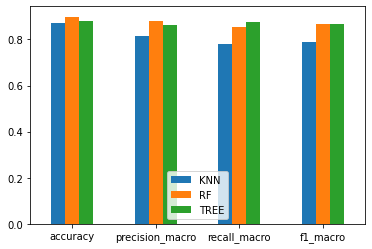

In [15]:
# Montando uma estrutura com os dados resultantes das médias calculadas pelo modelos classificadores para cada métrica
df_data = pd.DataFrame({'KNN': avg_scores_knn, 'RF': avg_scores_rf, 'TREE': avg_scores_tree}, index=scoring_list)

ax = df_data.plot.bar(rot=0)

O gráfico de barras mostra a comparação entre os modelos avaliados. Existe variações entre os modelos pra cada métrica, embora na métrica de acurácia a variação é muito pequena. 
De forma geral, o modelo classificador KNN teve na maioria das métricas menor performance que os modelos de Random Forest(RF) e Decision Tree(TREE). 
Já os modelos RF e TREE tiveram desempenho bastante semelhantes.

###Consultando o nível de importância de cada atributo pelos modelos classicadores

In [16]:
#RANDOM FOREST
clf_rf = RandomForestClassifier(n_estimators=300)
clf_rf = clf_rf.fit(X, y)

importance_rf = clf_rf.feature_importances_
importance_rf

array([0.35376226, 0.12120467, 0.16287087, 0.09637967, 0.09257811,
       0.05287688, 0.07864958, 0.02805643, 0.01362152])

In [17]:
#DECISION TREE
clf_tree = DecisionTreeClassifier()
clf_tree = clf_tree.fit(X, y)

importance_tree = clf_tree.feature_importances_
importance_tree

array([0.50585429, 0.08164597, 0.09334519, 0.09074046, 0.09963855,
       0.0443114 , 0.05559627, 0.01825281, 0.01061507])

###Selecionando as características mais importantes a partir dos modelos de classificação

[1 2 0]
[[-1 -1 -1 -1 -1  0  1  1  1]
 [ 1 -1  0  0 -1  0 -1  1  0]
 [ 1 -1  1 -1 -1  1  1  1  0]]


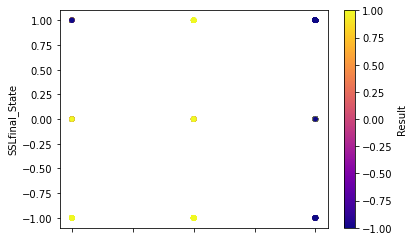

In [18]:
#RANDOM FOREST
model = SelectFromModel(clf_rf, prefit=True)
data_new = model.transform(X)

n_attrs = data_new.shape[1]
idx_most_important = importance_rf.argsort()[-n_attrs:]
print(idx_most_important)

name_important_attrs = np.array(X)[idx_most_important]
print(name_important_attrs)

ax = data.plot.scatter(x='SFH',
                        y='SSLfinal_State',
                        c='Result',
                        colormap='plasma')

[0]
[[ 1 -1  1 -1 -1  1  1  1  0]]


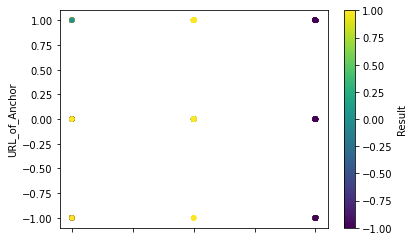

In [19]:
#DECISION TREE
model = SelectFromModel(clf_tree, prefit=True)
data_new = model.transform(X)

n_attrs = data_new.shape[1]
idx_most_important = importance_tree.argsort()[-n_attrs:]
print(idx_most_important)

name_important_attrs = np.array(X)[idx_most_important]
print(name_important_attrs)

ax = data.plot.scatter(x='SFH',
                        y='URL_of_Anchor',
                        c='Result',
                        colormap='viridis')

###Reduzindo dimensionalidade usando PCA

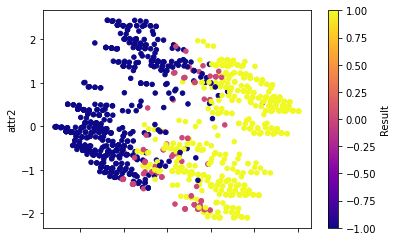

In [20]:
# Aplicando redução de dimensionalidade linear através do PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(data)

pca_df_data = pd.DataFrame(data=principalComponents, 
                           columns = ['attr1', 'attr2'])

pca_df_data = pd.concat([pca_df_data, data['Result']], axis = 1)

ax2 = pca_df_data.plot.scatter(x='attr1',
                      y='attr2',
                      c='Result',
                      colormap='plasma')

Os gráficos de dispersão (scatterplot) foram plotados para visualização das características (atributos) de maior importância/influência que foram classificadas pela Random Forest e pela Decision Tree.
Usando o mesmo tipo de gráfico tanto para Random Forest quanto para Decision Tree, ambos modelos apresentam resultados muito semelhantes, mesmo os modelos tendo classificados como importante um atributo diferente do outro.
Além de existir um positivo e grau elevado de relação entre os atributos, a semelhança conduz para uma conclusão de que há uma consistência nos dados bastante relevante.
Essa consistência dos dados é observada também mesmo reduzindo a dimensionalidade dos dados em apenas 2 atributos, através do PCA. 